In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [90]:
# Read the data
train_df = pd.read_csv('HR-Analytics/train.csv')
test_df = pd.read_csv('HR-Analytics/test.csv')

In [91]:
# Initial exploration
print("Train data shape:", train_df.shape)
print("Test data shape:", test_df.shape)

Train data shape: (54808, 14)
Test data shape: (23490, 13)


In [92]:
train_df.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [93]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


In [94]:
train_df.isnull().sum()

employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

In [95]:
def fillna(df,column,value):
    df[column].fillna(value,inplace=True)
    return df

train_df = fillna(train_df,"education","unknown")
train_df = fillna(train_df,"previous_year_rating",0.0)
#train_df.drop("employee_id",axis=1,inplace=True)

In [96]:
train_df.isnull().sum()

employee_id             0
department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met >80%           0
awards_won?             0
avg_training_score      0
is_promoted             0
dtype: int64

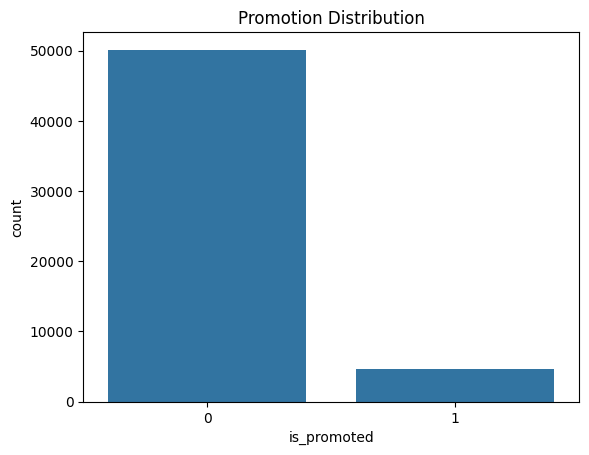

In [97]:
sns.countplot(x='is_promoted', data=train_df)
plt.title('Promotion Distribution')
plt.show()


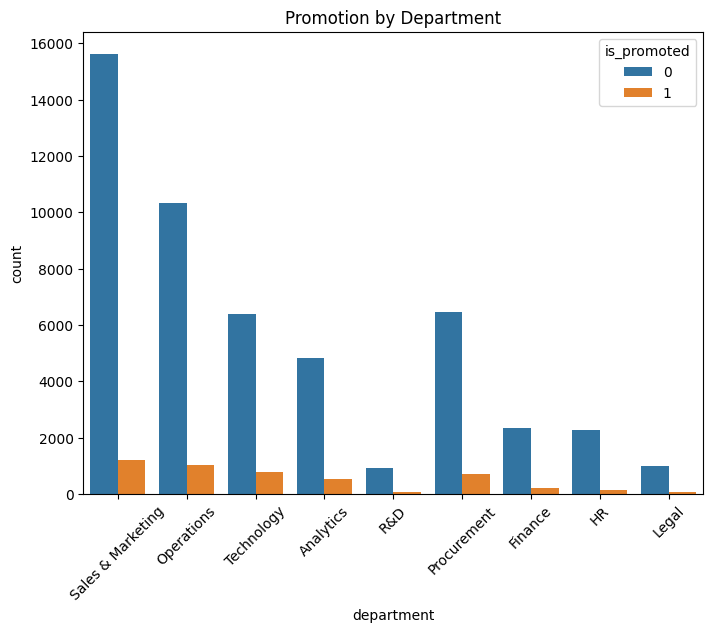

In [98]:
plt.figure(figsize=(8, 6))
sns.countplot(x='department', hue='is_promoted', data=train_df)
plt.title('Promotion by Department')
plt.xticks(rotation=45)
plt.show()

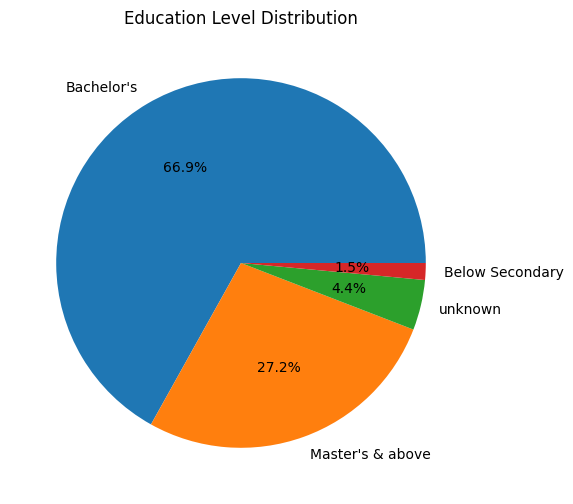

In [99]:
plt.figure(figsize=(6, 6))
education_counts = train_df['education'].value_counts()
plt.pie(education_counts, labels=education_counts.index, autopct='%1.1f%%')
plt.title('Education Level Distribution')
plt.show()

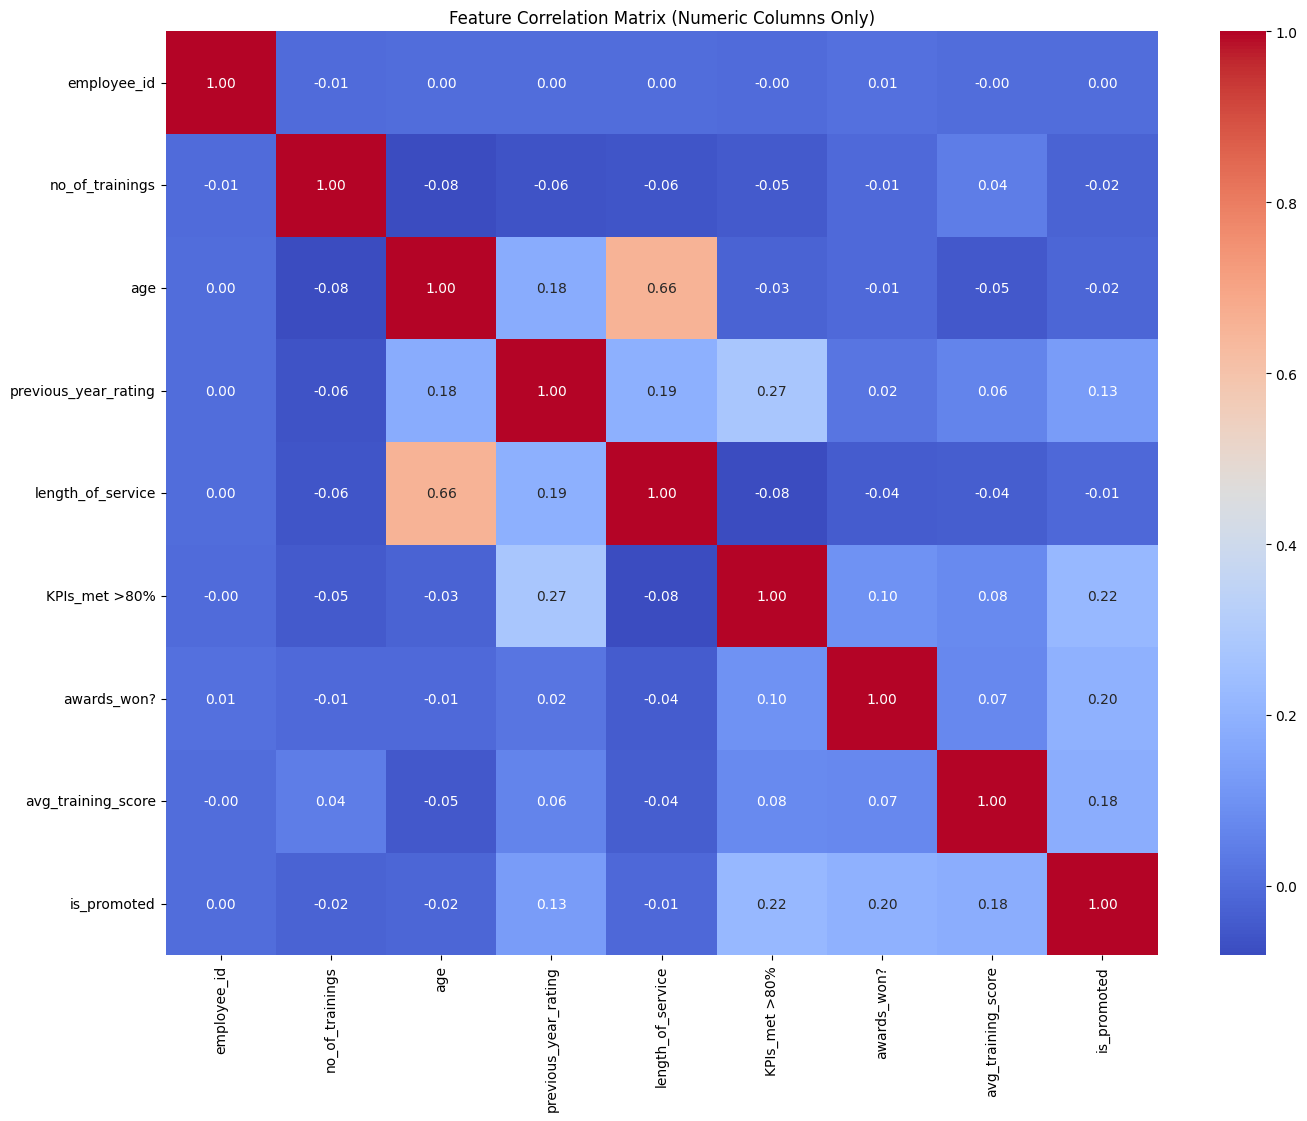

In [100]:
# Select only numeric columns for correlation
numeric_cols = train_df.select_dtypes(include=np.number).columns
corr_matrix = train_df[numeric_cols].corr()

# Visualization
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix (Numeric Columns Only)")
plt.show()


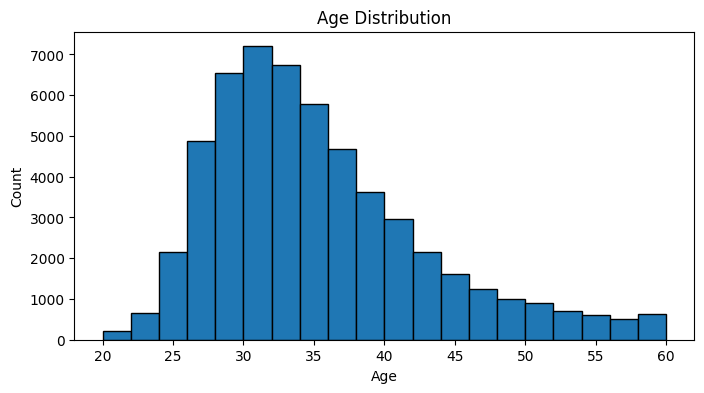

In [101]:
plt.figure(figsize=(8, 4))
plt.hist(train_df['age'], bins=20, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


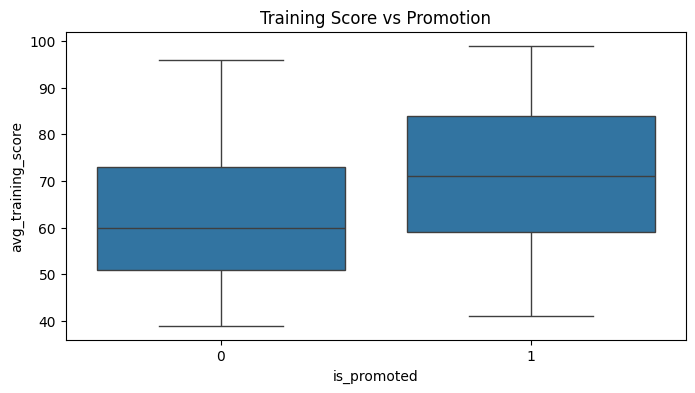

In [102]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='is_promoted', y='avg_training_score', data=train_df)
plt.title('Training Score vs Promotion')
plt.show()


In [103]:
train_df.drop(['employee_id', 'region'], axis=1, inplace=True)


In [104]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = ['department', 'education', 'gender', 'recruitment_channel']
encoders = {}

for col in categorical_cols:
    # Get train categories and most frequent value
    train_categories = train_df[col].astype(str).unique()
    mode_value = train_df[col].mode()[0]
    
    # Initialize encoder
    le = LabelEncoder()
    
    # Fit on train data
    train_encoded = le.fit_transform(train_df[col].astype(str))
    
    # Process test data - replace unseen categories with mode
    test_processed = test_df[col].astype(str).apply(
        lambda x: x if x in le.classes_ else mode_value
    )
    
    # Transform both datasets
    train_df[col] = train_encoded
    test_df[col] = le.transform(test_processed)
    
    encoders[col] = le


In [105]:
# Example: Create a binary feature for high training score
test_df['high_training_score'] = (test_df['avg_training_score'] > 80).astype(int)
train_df['high_training_score'] = (train_df['avg_training_score'] > 80).astype(int)

In [106]:
from sklearn.feature_selection import SelectKBest, f_classif

X = train_df.drop('is_promoted', axis=1)
y = train_df['is_promoted']

# Select top 10 features
selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print("Selected Features (SelectKBest):", selected_features)


Selected Features (SelectKBest): Index(['education', 'gender', 'no_of_trainings', 'age', 'previous_year_rating',
       'length_of_service', 'KPIs_met >80%', 'awards_won?',
       'avg_training_score', 'high_training_score'],
      dtype='object')


In [107]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

estimator = LogisticRegression(max_iter=1000)
rfe_selector = RFE(estimator, n_features_to_select=10, step=1)
rfe_selector = rfe_selector.fit(X, y)
rfe_features = X.columns[rfe_selector.support_]
print("Selected Features (RFE):", rfe_features)


Selected Features (RFE): Index(['department', 'education', 'no_of_trainings', 'age',
       'previous_year_rating', 'length_of_service', 'KPIs_met >80%',
       'awards_won?', 'avg_training_score', 'high_training_score'],
      dtype='object')


In [108]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1][:10]
top_features = X.columns[indices]
print("Top Features (Random Forest):", top_features)


Top Features (Random Forest): Index(['avg_training_score', 'age', 'length_of_service', 'department',
       'previous_year_rating', 'KPIs_met >80%', 'recruitment_channel',
       'awards_won?', 'no_of_trainings', 'education'],
      dtype='object')


In [109]:
final_features = list(set(selected_features) | set(rfe_features) | set(top_features))
print("Final Feature Set:", final_features)


Final Feature Set: ['recruitment_channel', 'length_of_service', 'age', 'no_of_trainings', 'avg_training_score', 'KPIs_met >80%', 'education', 'previous_year_rating', 'department', 'gender', 'awards_won?', 'high_training_score']


In [110]:
from imblearn.over_sampling import SMOTE

X_balanced = train_df[final_features]
y_balanced = train_df['is_promoted']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_balanced, y_balanced)
print("Class distribution after SMOTE:", np.bincount(y_resampled))


Class distribution after SMOTE: [50140 50140]


In [111]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)


In [112]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_val)
y_proba_lr = lr.predict_proba(X_val)[:, 1]

print("Logistic Regression Results:")
print(classification_report(y_val, y_pred_lr))
print("ROC AUC Score:", roc_auc_score(y_val, y_proba_lr))


Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.71      0.70      0.70     10028
           1       0.70      0.72      0.71     10028

    accuracy                           0.71     20056
   macro avg       0.71      0.71      0.71     20056
weighted avg       0.71      0.71      0.71     20056

ROC AUC Score: 0.7911191503837123


In [113]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_val)
y_proba_dt = dt.predict_proba(X_val)[:, 1]

print("Decision Tree Results:")
print(classification_report(y_val, y_pred_dt))
print("ROC AUC Score:", roc_auc_score(y_val, y_proba_dt))


Decision Tree Results:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93     10028
           1       0.91      0.95      0.93     10028

    accuracy                           0.93     20056
   macro avg       0.93      0.93      0.93     20056
weighted avg       0.93      0.93      0.93     20056

ROC AUC Score: 0.9301802082211291


In [114]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)
y_proba_rf = rf.predict_proba(X_val)[:, 1]

print("Random Forest Results:")
print(classification_report(y_val, y_pred_rf))
print("ROC AUC Score:", roc_auc_score(y_val, y_proba_rf))


Random Forest Results:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95     10028
           1       0.94      0.96      0.95     10028

    accuracy                           0.95     20056
   macro avg       0.95      0.95      0.95     20056
weighted avg       0.95      0.95      0.95     20056

ROC AUC Score: 0.9877335035494552


In [115]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_val)
y_proba_xgb = xgb.predict_proba(X_val)[:, 1]

print("XGBoost Results:")
print(classification_report(y_val, y_pred_xgb))
print("ROC AUC Score:", roc_auc_score(y_val, y_proba_xgb))


/media/z-deb/Local_Disk/python_rut/my_project/env/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:32:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Results:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89     10028
           1       0.89      0.90      0.90     10028

    accuracy                           0.90     20056
   macro avg       0.90      0.90      0.90     20056
weighted avg       0.90      0.90      0.90     20056

ROC AUC Score: 0.9701113656790902


In [116]:
import pandas as pd

results = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'Accuracy': [
        lr.score(X_val, y_val),
        dt.score(X_val, y_val),
        rf.score(X_val, y_val),
        xgb.score(X_val, y_val)
    ],
    'ROC AUC': [
        roc_auc_score(y_val, y_proba_lr),
        roc_auc_score(y_val, y_proba_dt),
        roc_auc_score(y_val, y_proba_rf),
        roc_auc_score(y_val, y_proba_xgb)
    ]
}

results_df = pd.DataFrame(results)
print(results_df)


                 Model  Accuracy   ROC AUC
0  Logistic Regression  0.707270  0.791119
1        Decision Tree  0.926855  0.930180
2        Random Forest  0.946600  0.987734
3              XGBoost  0.895692  0.970111


In [117]:
test_df['education'].fillna('unknown', inplace=True)

In [118]:
test_df['previous_year_rating'].fillna(0, inplace=True)

In [119]:
test_df.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,high_training_score
0,8724,8,region_26,0,1,2,1,24,0.0,1,1,0,77,0
1,74430,2,region_4,0,0,0,1,31,3.0,5,0,0,51,0
2,72255,7,region_13,0,1,0,1,31,1.0,4,0,0,47,0
3,38562,5,region_2,0,0,0,3,31,2.0,9,0,0,65,0
4,64486,1,region_29,0,1,2,1,30,4.0,7,0,0,61,0


In [120]:
test_df.isnull().sum()

employee_id             0
department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met >80%           0
awards_won?             0
avg_training_score      0
high_training_score     0
dtype: int64

In [121]:
from sklearn.preprocessing import LabelEncoder

# Find categorical columns
categorical_cols = test_df.select_dtypes(include=['object', 'category']).columns

# Apply label encoding to each categorical column
le = LabelEncoder()
for col in categorical_cols:
    test_df[col + '_encoded'] = le.fit_transform(test_df[col])


In [122]:
best_model = RandomForestClassifier(n_estimators=100, random_state=42)
best_model.fit(X_resampled, y_resampled)  # Using full SMOTE-resampled data


RandomForestClassifier(random_state=42)

In [123]:
test_predictions = best_model.predict(test_df[final_features])


In [124]:
submission = pd.DataFrame({
    'employee_id': test_df['employee_id'],
    'is_promoted': test_predictions
})

submission.to_csv('submission.csv', index=False)


In [125]:
import os

# Create output directory if needed
os.makedirs('output', exist_ok=True)

# Create submission DataFrame
submission = pd.DataFrame({
    'employee_id': test_df['employee_id'],
    'is_promoted': test_predictions
})

# Save with explicit path and verification
filepath = os.path.join('output', 'submission.csv')
submission.to_csv(filepath, index=False)

# Verify creation
if os.path.exists(filepath):
    print(f"✅ File saved successfully: {filepath}")
    print(f"📄 File contains {len(submission)} rows")
else:
    print("❌ File creation failed - check permissions/paths")


✅ File saved successfully: output/submission.csv
📄 File contains 23490 rows


In [126]:
promotions= pd.read_csv("submission.csv")

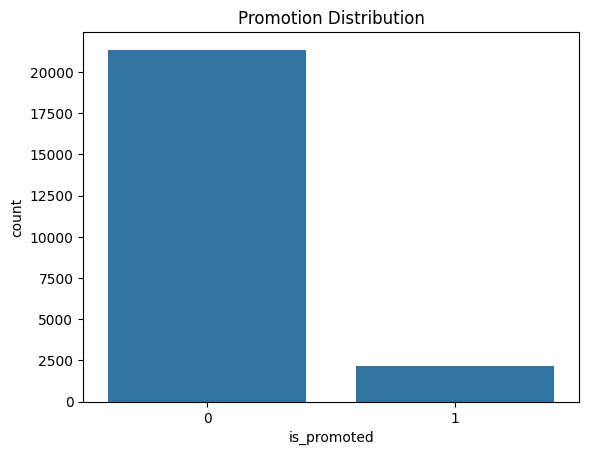

In [127]:
sns.countplot(x='is_promoted', data=promotions)
plt.title('Promotion Distribution')
plt.show()


In [128]:

counts = promotions['is_promoted'].value_counts()
print(counts)


is_promoted
0    21352
1     2138
Name: count, dtype: int64
